# Implementación de privacidad diferencial en una Red Neuronal para la Detección de Cáncer con PyTorch

# Importación de Bibliotecas

En este bloque de código, se realizan las importaciones necesarias de bibliotecas que se utilizarán a lo largo del proyecto. A continuación, se describen las bibliotecas importadas:

- **`os`**: Biblioteca estándar de Python para interactuar con el sistema operativo, se utiliza para operaciones relacionadas con el sistema de archivos.

- **`pandas`**: Biblioteca ampliamente utilizada para la manipulación y análisis de datos tabulares, como la carga de datos desde archivos CSV.

- **`numpy`**: Biblioteca para realizar cálculos numéricos eficientes, incluida la manipulación de matrices y vectores.

- **`torch`**: Biblioteca PyTorch, que es una plataforma de aprendizaje profundo ampliamente utilizada para la construcción y entrenamiento de redes neuronales.

- **`torch.utils.data`**: Módulo de PyTorch que proporciona herramientas para trabajar con conjuntos de datos y generadores de lotes (batching) como `DataLoader`.

- **`nn`**: Módulo de PyTorch que contiene clases y funciones para la construcción de modelos de redes neuronales, como capas y funciones de activación.

- **`optim`**: Módulo de PyTorch que contiene optimizadores para el entrenamiento de modelos de aprendizaje profundo, como el descenso de gradiente estocástico (SGD).

- **`sklearn.metrics`**: Módulo de la biblioteca scikit-learn que proporciona métricas de evaluación para evaluar el rendimiento de modelos de aprendizaje automático, como `accuracy_score` para calcular la precisión.

- **`sklearn.model_selection`**: Módulo de scikit-learn que proporciona herramientas para dividir conjuntos de datos en conjuntos de entrenamiento y prueba, entre otras tareas relacionadas con la selección de modelos.

- **`tqdm`**: Biblioteca que proporciona una barra de progreso visual para tareas iterativas, lo que es útil para realizar un seguimiento del progreso durante el entrenamiento.

- **`sklearn.datasets`**: Módulo de scikit-learn que contiene conjuntos de datos de ejemplo, como `load_breast_cancer`, que se utiliza para cargar el conjunto de datos de cáncer de mama.

- **`opacus`**: Biblioteca utilizada para incorporar privacidad diferencial a los modelos de PyTorch.




In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.datasets import load_breast_cancer
from opacus import PrivacyEngine

# Cargar el Conjunto de Datos y Dividirlo en Entrenamiento y Prueba

En esta sección del código, se realiza la preparación de los datos. A continuación, se describen los pasos clave:

1. **Carga del Conjunto de Datos**: Se utiliza la función `load_breast_cancer()` para cargar el conjunto de datos de cáncer de mama proporcionado por scikit-learn. Los datos se almacenan en las variables `X` (características) y `y` (etiquetas).

2. **División en Conjuntos de Entrenamiento y Prueba**: Los datos se dividen en dos conjuntos: entrenamiento y prueba, utilizando la función `train_test_split()`. Se reserva el 20% de los datos para el conjunto de prueba, y se utiliza una semilla (`random_state`) para garantizar reproducibilidad.

3. **Conversión a Tensores de PyTorch**: Los datos, que inicialmente son matrices numpy, se convierten en tensores de PyTorch. Se utilizan tensores de tipo `float32` para las características (`X_train_tensor` y `X_test_tensor`) y tensores de tipo `long` para las etiquetas (`y_train_tensor` y `y_test_tensor`).

4. **Creación de Conjuntos de Datos TensorDataset**: Se crean conjuntos de datos `TensorDataset` tanto para el conjunto de entrenamiento como para el de prueba. Estos conjuntos permiten combinar las características y las etiquetas en un formato que PyTorch puede manejar fácilmente.

5. **Creación de DataLoaders**: Finalmente, se crean DataLoaders para el conjunto de entrenamiento y el conjunto de prueba utilizando los conjuntos de datos `TensorDataset`. Estos DataLoaders se utilizan posteriormente para iterar sobre los datos en lotes durante el entrenamiento y la evaluación de la red neuronal.

Este proceso asegura que los datos estén listos y en el formato adecuado para ser utilizados en el entrenamiento y prueba de la red neuronal.


In [2]:
# Cargar el conjunto de datos y dividirlo en entrenamiento y prueba
breast_dataset = load_breast_cancer()
X = breast_dataset.data
y = breast_dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Convertir los datos de numpy a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Crear conjuntos de datos TensorDataset para entrenamiento y prueba
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear DataLoaders para entrenamiento y prueba
batch_size = 15  # Tamaño del lote
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definición de la Arquitectura de la Red Neuronal

En este bloque de código, se define la arquitectura de la red neuronal. A continuación, se describen los aspectos clave de la arquitectura:

- **Clase `Red`**: Se define una clase llamada `Red` que hereda de `nn.Module`, una clase base de PyTorch para la construcción de modelos de redes neuronales.

- **Módulos Lineales**: La red consta de tres capas lineales definidas mediante `nn.Linear`. Cada capa lineal se describe como sigue:
  - `self.linear1`: Primera capa lineal con `n_entradas` neuronas de entrada y 15 neuronas de salida. La función de activación utilizada en esta capa es la función sigmoide (`torch.sigmoid`).
  - `self.linear2`: Segunda capa lineal con 15 neuronas de entrada y 8 neuronas de salida. También utiliza la función sigmoide como función de activación.
  - `self.linear3`: Tercera capa lineal con 8 neuronas de entrada y 2 neuronas de salida. Esta capa es la capa de salida utilizada para la clasificación binaria, por lo que no se aplica una función de activación.

- **Método `forward`**: En el método `forward`, se define cómo se propagan las entradas a través de la red. Se aplican las funciones sigmoide en las dos primeras capas lineales (`pred_1` y `pred_2`) y no se aplica ninguna función de activación en la capa de salida (`pred_f`). La salida final de la red se obtiene de `pred_f`.


In [3]:
# Definir la arquitectura de la red neuronal
class Red(nn.Module):
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)
        self.linear2 = nn.Linear(15, 8)
        self.linear3 = nn.Linear(8, 2)  # 2 salidas para clasificación binaria

    def forward(self, inputs):
        pred_1 = torch.sigmoid(self.linear1(inputs))
        pred_2 = torch.sigmoid(self.linear2(pred_1))
        pred_f = self.linear3(pred_2)
        return pred_f

# Definición de Hiperparámetros y Creación del Modelo

En esta sección del código, se definen los hiperparámetros clave para la configuración del entrenamiento y se crea una instancia del modelo de red neuronal. A continuación, se describen los aspectos clave:

- **Tasa de Aprendizaje (lr)**: Se define la tasa de aprendizaje (`lr`) con un valor de 0.001. Esta tasa de aprendizaje determina el tamaño de los pasos que se toman durante el proceso de optimización.

- **Número de Entradas (n_entradas)**: El número de neuronas de entrada se obtiene a partir de la forma de los datos de entrenamiento (`X_train`). Esto se hace con el fin de configurar correctamente la capa de entrada de la red.

- **Creación del Modelo**: Se crea una instancia del modelo de red neuronal llamado `model`. El modelo se inicializa con la arquitectura definida previamente en la clase `Red` y se pasa el número de entradas correspondiente.

- **Función de Pérdida (loss_fn)**: Se define la función de pérdida que se utilizará durante el entrenamiento. En este caso, se utiliza `nn.CrossEntropyLoss()`, que es adecuada para problemas de clasificación.

- **Optimizador**: Se crea un optimizador llamado `optimizer` utilizando el algoritmo de descenso de gradiente estocástico (SGD). El optimizador se configura para actualizar los parámetros del modelo con la tasa de aprendizaje definida anteriormente.



In [4]:
# Definir hiperparámetros y crear el modelo
lr = 0.001

n_entradas = X_train.shape[1]
model = Red(n_entradas=n_entradas)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Implementación de Privacidad Diferencial

En este bloque de código, se lleva a cabo la implementación de la privacidad diferencial a tu modelo de PyTorch utilizando la biblioteca Opacus. A continuación, se describen los aspectos clave de esta implementación:

- **`PrivacyEngine()`**: Se crea una instancia de la clase `PrivacyEngine` de Opacus, que se utilizará para configurar y aplicar privacidad diferencial al modelo.

- **`make_private_with_epsilon()`**: Se llama al método `make_private_with_epsilon()` de `PrivacyEngine` para hacer que el modelo sea privado con un cierto nivel de epsilon, que es un parámetro que controla el nivel de privacidad. Los siguientes argumentos se pasan a este método:
  - `module=model`: El modelo al que se aplicará la privacidad diferencial.
  - `optimizer=optimizer`: El optimizador utilizado para el entrenamiento.
  - `data_loader=train_loader`: El DataLoader que contiene los datos de entrenamiento.
  - `epochs=100`: El número de épocas de entrenamiento.
  - `target_epsilon=100`: El valor objetivo de epsilon, que controla la magnitud del ruido añadido a las actualizaciones de los parámetros del modelo. Un valor más alto de epsilon implica una menor privacidad.
  - `target_delta=0.001`: El valor objetivo de delta, que es una probabilidad de fugas de privacidad. Un valor más bajo de delta implica una mejor privacidad.
  - `max_grad_norm=1`: La norma máxima de los gradientes, que limita la magnitud de los gradientes para mejorar la privacidad.

Esta implementación se encarga de ajustar el modelo y el proceso de entrenamiento para garantizar la privacidad diferencial de los datos. La configuración de los parámetros `epsilon` y `delta` es crucial para controlar el nivel de privacidad y es importante ajustarlos según los requisitos de privacidad de tu aplicación.


In [5]:
privacy_engine = PrivacyEngine()
model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=100,
    target_epsilon=100,
    target_delta=0.001,
    max_grad_norm=1,
)

C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter priv

# Monitorización de Privacidad Diferencial por Época

En esta extensión del código, se ha añadido la monitorización del nivel de privacidad diferencial (epsilon) por época. Esto es importante para evaluar el grado de privacidad garantizado durante el entrenamiento del modelo. A continuación, se describen los aspectos clave de esta extensión:

- **Listas para Almacenar Métricas por Época**: Se han creado cuatro listas: `MLossXepoc`, `ACCxEpoc`, `epochX`, y `EpsXEpoc`, que se utilizarán para almacenar la pérdida promedio, la precisión, el número de época y el nivel de privacidad diferencial (epsilon) respectivamente.

- **`train()` con Cálculo de Epsilon**: La función `train()` ahora calcula y registra el nivel de privacidad diferencial (epsilon) por época utilizando `privacy_engine.get_epsilon(delta=delta)`. Esto proporciona información sobre la privacidad garantizada en cada época de entrenamiento.

- **Registros de Resultados**: Se registran los resultados, incluyendo la pérdida promedio, la precisión, el nivel de privacidad (ε), y el valor de δ en la salida de cada época de entrenamiento. Esto permite una monitorización detallada del rendimiento del modelo y la privacidad diferencial en el transcurso del entrenamiento.

- **Bucle de Épocas**: Se incluye un bucle `for` que itera a través de las épocas de entrenamiento (en este caso, 1 a 99) y llama a la función `train()` con los parámetros necesarios.

La monitorización de epsilon es fundamental para evaluar el grado de privacidad ofrecido por el modelo y ajustar los hiperparámetros, como el valor de delta, para cumplir con los requisitos de privacidad específicos de tu aplicación.


In [6]:
MLossXepoc = []
ACCxEpoc = []
epochX = []
EpsXEpoc = []

def train(model, train_loader, optimizer, epoch, device, delta):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    correct = 0  # Inicializar el contador de predicciones correctas
    total = 0    # Inicializar el contador de ejemplos totales
    
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # Calcular la precisión
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total  # Calcular la precisión en porcentaje
    mean_loss = np.mean(losses)*100
    epsilon = privacy_engine.get_epsilon(delta=delta)
    
    MLossXepoc.append(mean_loss)
    ACCxEpoc.append(accuracy)
    epochX.append(epoch)
    EpsXEpoc.append(epsilon)
    
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} "
        f"Accuracy: {accuracy:.2f}% "  # Mostrar la precisión
        f"(ε = {epsilon:.2f}, δ = {delta})")

# Luego, dentro de tu bucle de épocas:
for epoch in range(1, 100):
    train(model, train_loader, optimizer, epoch, device="cpu", delta=1e-3)

  0%|          | 0/31 [00:00<?, ?it/s]C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 31/31 [00:00<00:00, 265.12it/s]


Train Epoch: 1 	Loss: 0.711360 Accuracy: 36.70% (ε = 7.79, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 310.24it/s]


Train Epoch: 2 	Loss: 0.703160 Accuracy: 36.70% (ε = 10.22, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 269.65it/s]


Train Epoch: 3 	Loss: 0.699373 Accuracy: 36.70% (ε = 12.19, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 254.26it/s]


Train Epoch: 4 	Loss: 0.696113 Accuracy: 36.26% (ε = 13.92, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 256.99it/s]


Train Epoch: 5 	Loss: 0.692832 Accuracy: 52.09% (ε = 15.50, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 279.42it/s]


Train Epoch: 6 	Loss: 0.689328 Accuracy: 63.30% (ε = 16.98, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 314.23it/s]


Train Epoch: 7 	Loss: 0.686064 Accuracy: 63.52% (ε = 18.38, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 262.47it/s]


Train Epoch: 8 	Loss: 0.682911 Accuracy: 63.30% (ε = 19.72, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 238.67it/s]


Train Epoch: 9 	Loss: 0.681006 Accuracy: 63.30% (ε = 21.01, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 252.26it/s]


Train Epoch: 10 	Loss: 0.677900 Accuracy: 63.30% (ε = 22.26, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 269.68it/s]


Train Epoch: 11 	Loss: 0.674315 Accuracy: 63.30% (ε = 23.47, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 245.13it/s]


Train Epoch: 12 	Loss: 0.672765 Accuracy: 63.30% (ε = 24.65, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 254.80it/s]


Train Epoch: 13 	Loss: 0.671531 Accuracy: 63.30% (ε = 25.81, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 244.28it/s]


Train Epoch: 14 	Loss: 0.668388 Accuracy: 63.30% (ε = 26.94, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 243.04it/s]


Train Epoch: 15 	Loss: 0.667431 Accuracy: 63.30% (ε = 28.05, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 262.33it/s]


Train Epoch: 16 	Loss: 0.664543 Accuracy: 63.30% (ε = 29.14, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 239.23it/s]


Train Epoch: 17 	Loss: 0.664018 Accuracy: 63.30% (ε = 30.21, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 313.25it/s]


Train Epoch: 18 	Loss: 0.661080 Accuracy: 63.30% (ε = 31.27, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 284.34it/s]


Train Epoch: 19 	Loss: 0.661195 Accuracy: 63.30% (ε = 32.31, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 270.99it/s]


Train Epoch: 20 	Loss: 0.655178 Accuracy: 63.30% (ε = 33.34, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 277.62it/s]


Train Epoch: 21 	Loss: 0.657425 Accuracy: 63.30% (ε = 34.35, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 272.34it/s]


Train Epoch: 22 	Loss: 0.656683 Accuracy: 63.30% (ε = 35.36, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 276.74it/s]


Train Epoch: 23 	Loss: 0.651531 Accuracy: 63.30% (ε = 36.35, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 320.41it/s]


Train Epoch: 24 	Loss: 0.657959 Accuracy: 63.30% (ε = 37.34, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 272.90it/s]


Train Epoch: 25 	Loss: 0.659958 Accuracy: 63.30% (ε = 38.31, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 275.46it/s]


Train Epoch: 26 	Loss: 0.652644 Accuracy: 63.30% (ε = 39.28, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 287.06it/s]


Train Epoch: 27 	Loss: 0.655054 Accuracy: 63.30% (ε = 40.23, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 248.96it/s]


Train Epoch: 28 	Loss: 0.655206 Accuracy: 63.30% (ε = 41.18, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 244.40it/s]


Train Epoch: 29 	Loss: 0.661206 Accuracy: 63.30% (ε = 42.13, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 268.20it/s]


Train Epoch: 30 	Loss: 0.649476 Accuracy: 63.30% (ε = 43.06, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 249.64it/s]


Train Epoch: 31 	Loss: 0.650770 Accuracy: 63.30% (ε = 43.99, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 279.30it/s]


Train Epoch: 32 	Loss: 0.657090 Accuracy: 63.30% (ε = 44.91, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 278.78it/s]


Train Epoch: 33 	Loss: 0.664105 Accuracy: 63.30% (ε = 45.83, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 278.07it/s]


Train Epoch: 34 	Loss: 0.655709 Accuracy: 63.30% (ε = 46.74, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 310.70it/s]


Train Epoch: 35 	Loss: 0.659838 Accuracy: 63.30% (ε = 47.64, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 329.77it/s]


Train Epoch: 36 	Loss: 0.653759 Accuracy: 63.30% (ε = 48.54, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 279.34it/s]


Train Epoch: 37 	Loss: 0.662271 Accuracy: 63.30% (ε = 49.43, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 341.40it/s]


Train Epoch: 38 	Loss: 0.666916 Accuracy: 63.30% (ε = 50.32, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 280.02it/s]


Train Epoch: 39 	Loss: 0.660743 Accuracy: 63.30% (ε = 51.20, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 258.97it/s]


Train Epoch: 40 	Loss: 0.665951 Accuracy: 63.30% (ε = 52.08, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 253.34it/s]


Train Epoch: 41 	Loss: 0.663122 Accuracy: 63.30% (ε = 52.96, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 276.13it/s]


Train Epoch: 42 	Loss: 0.664227 Accuracy: 63.30% (ε = 53.83, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 274.09it/s]


Train Epoch: 43 	Loss: 0.677792 Accuracy: 63.30% (ε = 54.70, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 330.44it/s]


Train Epoch: 44 	Loss: 0.671323 Accuracy: 63.30% (ε = 55.56, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 282.02it/s]


Train Epoch: 45 	Loss: 0.664450 Accuracy: 63.30% (ε = 56.42, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 270.53it/s]


Train Epoch: 46 	Loss: 0.670175 Accuracy: 63.30% (ε = 57.27, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 280.14it/s]


Train Epoch: 47 	Loss: 0.667150 Accuracy: 63.30% (ε = 58.13, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 322.03it/s]


Train Epoch: 48 	Loss: 0.673123 Accuracy: 63.30% (ε = 58.97, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 247.69it/s]


Train Epoch: 49 	Loss: 0.687729 Accuracy: 63.30% (ε = 59.82, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 249.72it/s]


Train Epoch: 50 	Loss: 0.680404 Accuracy: 63.30% (ε = 60.66, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 316.86it/s]


Train Epoch: 51 	Loss: 0.686324 Accuracy: 63.30% (ε = 61.50, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 284.02it/s]


Train Epoch: 52 	Loss: 0.679369 Accuracy: 63.30% (ε = 62.34, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 324.52it/s]


Train Epoch: 53 	Loss: 0.695107 Accuracy: 63.30% (ε = 63.17, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 270.05it/s]


Train Epoch: 54 	Loss: 0.692151 Accuracy: 63.30% (ε = 64.00, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 281.58it/s]


Train Epoch: 55 	Loss: 0.698362 Accuracy: 63.30% (ε = 64.83, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 324.24it/s]


Train Epoch: 56 	Loss: 0.690446 Accuracy: 63.30% (ε = 65.65, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 245.16it/s]


Train Epoch: 57 	Loss: 0.696767 Accuracy: 63.30% (ε = 66.47, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 246.77it/s]


Train Epoch: 58 	Loss: 0.693523 Accuracy: 63.30% (ε = 67.29, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 328.32it/s]


Train Epoch: 59 	Loss: 0.689740 Accuracy: 63.30% (ε = 68.11, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 268.47it/s]


Train Epoch: 60 	Loss: 0.712340 Accuracy: 63.30% (ε = 68.92, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 286.38it/s]


Train Epoch: 61 	Loss: 0.698123 Accuracy: 63.30% (ε = 69.73, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 317.83it/s]


Train Epoch: 62 	Loss: 0.698984 Accuracy: 63.30% (ε = 70.54, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 275.61it/s]


Train Epoch: 63 	Loss: 0.707073 Accuracy: 63.30% (ε = 71.35, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 237.63it/s]


Train Epoch: 64 	Loss: 0.696853 Accuracy: 63.30% (ε = 72.16, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 238.31it/s]


Train Epoch: 65 	Loss: 0.704413 Accuracy: 63.30% (ε = 72.96, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 274.14it/s]


Train Epoch: 66 	Loss: 0.717167 Accuracy: 63.30% (ε = 73.76, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 318.73it/s]


Train Epoch: 67 	Loss: 0.706600 Accuracy: 63.30% (ε = 74.56, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 282.28it/s]


Train Epoch: 68 	Loss: 0.703170 Accuracy: 63.30% (ε = 75.36, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 274.98it/s]


Train Epoch: 69 	Loss: 0.709252 Accuracy: 63.30% (ε = 76.15, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 255.39it/s]


Train Epoch: 70 	Loss: 0.716804 Accuracy: 63.30% (ε = 76.94, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 267.76it/s]


Train Epoch: 71 	Loss: 0.718058 Accuracy: 63.30% (ε = 77.73, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 249.63it/s]


Train Epoch: 72 	Loss: 0.720275 Accuracy: 63.30% (ε = 78.52, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 257.36it/s]


Train Epoch: 73 	Loss: 0.703641 Accuracy: 63.30% (ε = 79.31, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 273.85it/s]


Train Epoch: 74 	Loss: 0.716371 Accuracy: 63.30% (ε = 80.10, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 260.19it/s]


Train Epoch: 75 	Loss: 0.717450 Accuracy: 63.30% (ε = 80.88, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 293.83it/s]


Train Epoch: 76 	Loss: 0.706982 Accuracy: 63.30% (ε = 81.66, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 246.27it/s]


Train Epoch: 77 	Loss: 0.714025 Accuracy: 63.30% (ε = 82.44, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 250.51it/s]


Train Epoch: 78 	Loss: 0.727617 Accuracy: 63.30% (ε = 83.22, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 271.96it/s]


Train Epoch: 79 	Loss: 0.710445 Accuracy: 63.30% (ε = 84.00, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 335.64it/s]


Train Epoch: 80 	Loss: 0.729478 Accuracy: 63.30% (ε = 84.78, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 330.27it/s]


Train Epoch: 81 	Loss: 0.718584 Accuracy: 63.30% (ε = 85.55, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 277.43it/s]


Train Epoch: 82 	Loss: 0.726235 Accuracy: 63.30% (ε = 86.32, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 261.33it/s]


Train Epoch: 83 	Loss: 0.715268 Accuracy: 63.30% (ε = 87.09, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 271.43it/s]


Train Epoch: 84 	Loss: 0.722346 Accuracy: 63.30% (ε = 87.86, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 311.63it/s]


Train Epoch: 85 	Loss: 0.735859 Accuracy: 63.30% (ε = 88.63, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 275.16it/s]


Train Epoch: 86 	Loss: 0.730657 Accuracy: 63.30% (ε = 89.40, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 270.40it/s]


Train Epoch: 87 	Loss: 0.732818 Accuracy: 63.30% (ε = 90.16, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 253.69it/s]


Train Epoch: 88 	Loss: 0.739342 Accuracy: 63.30% (ε = 90.93, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 270.83it/s]


Train Epoch: 89 	Loss: 0.734482 Accuracy: 63.30% (ε = 91.69, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 274.19it/s]


Train Epoch: 90 	Loss: 0.722613 Accuracy: 63.30% (ε = 92.45, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 279.13it/s]


Train Epoch: 91 	Loss: 0.748697 Accuracy: 63.30% (ε = 93.21, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 285.40it/s]


Train Epoch: 92 	Loss: 0.731149 Accuracy: 63.30% (ε = 93.97, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 256.21it/s]


Train Epoch: 93 	Loss: 0.732213 Accuracy: 63.30% (ε = 94.73, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 270.95it/s]


Train Epoch: 94 	Loss: 0.739529 Accuracy: 63.30% (ε = 95.48, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 276.29it/s]


Train Epoch: 95 	Loss: 0.739710 Accuracy: 63.30% (ε = 96.24, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 312.10it/s]


Train Epoch: 96 	Loss: 0.747991 Accuracy: 63.30% (ε = 96.99, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 275.17it/s]


Train Epoch: 97 	Loss: 0.742225 Accuracy: 63.30% (ε = 97.75, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 236.52it/s]


Train Epoch: 98 	Loss: 0.736148 Accuracy: 63.30% (ε = 98.50, δ = 0.001)


100%|██████████| 31/31 [00:00<00:00, 280.52it/s]


Train Epoch: 99 	Loss: 0.743899 Accuracy: 63.30% (ε = 99.25, δ = 0.001)


In [7]:
import matplotlib.pyplot as plt

def plot_metrics(title, x_label, y_label, data1, label1, data2, label2, x_data, filename):
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico
    plt.plot(x_data, data1, marker='o', linestyle='--', color='b', label=label1, linewidth=2)
    plt.plot(x_data, data2, marker='o', linestyle='--', color='g', label=label2, linewidth=2)
    plt.xlabel(x_label, fontsize=14)  # Etiqueta del eje x
    plt.ylabel(y_label, fontsize=14)  # Etiqueta del eje y
    plt.title(title, fontsize=16)  # Título del gráfico
    plt.legend(fontsize=12)  # Leyenda
    plt.grid(True, linestyle='--', alpha=0.7)  # Cuadrícula con estilo
    plt.tight_layout()  # Ajuste de diseño
    plt.savefig(filename)  # Guardar el gráfico como imagen
    plt.show()

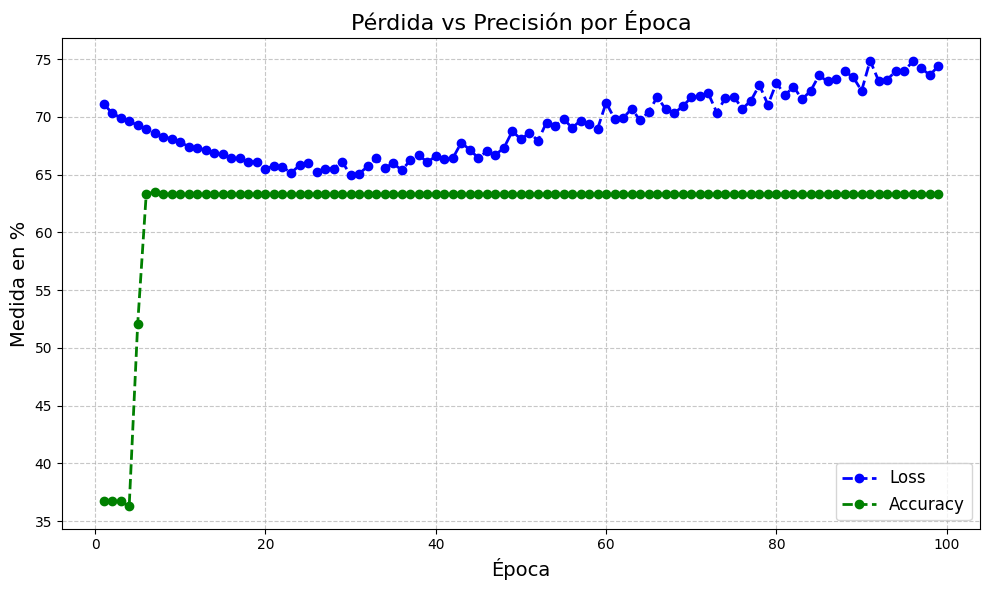

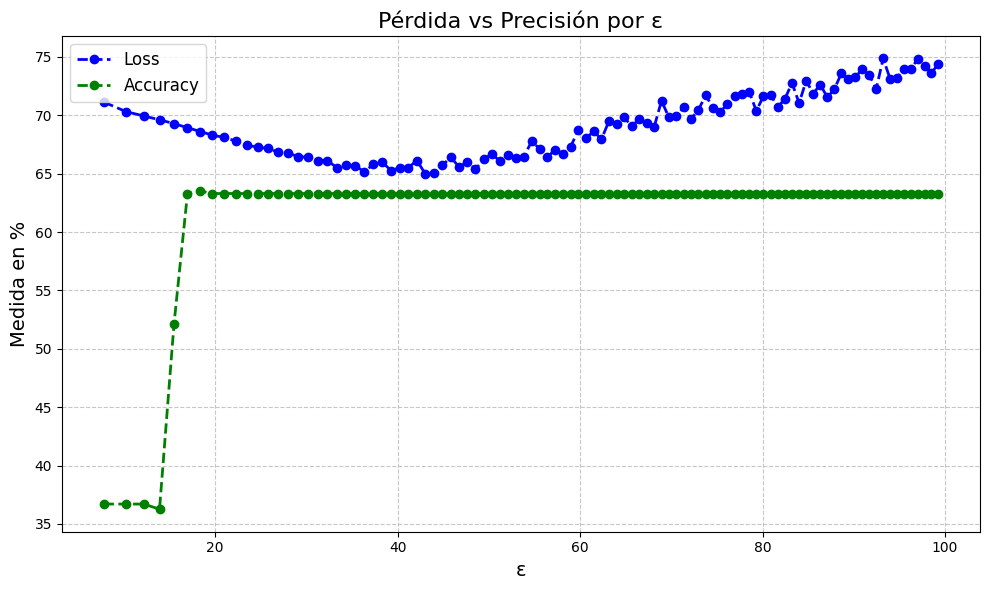

In [8]:
plot_metrics('Pérdida vs Precisión por Época', 'Época', 'Medida en %', MLossXepoc, 'Loss', ACCxEpoc, 'Accuracy', epochX, 'loss_vs_acc.png')
plot_metrics('Pérdida vs Precisión por ε', 'ε', 'Medida en %', MLossXepoc, 'Loss', ACCxEpoc, 'Accuracy', EpsXEpoc, 'loss_vs_accuracy_by_epsilon.png')